# Boundary Value Problems (BVPs) and Partial Differential Equations (PDEs)
This notebook takes us through various ways to solve BVPs and PDEs in Python, with examples drawn mainly from fluid mechanics and transport (eg. thermal diffusion).


In [2]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-4

## Plane Poiseuille flow - BVP solve by shooting method

One approach to solving BVPs is to use the shooting method. The reason we cannot use an initial value solver for a BVP is that there is not enough information at the initial value to start. In the shooting method, we take the function value at the initial point, and guess what the function derivatives are so that we can do an integration. If our guess was good, then the solution will go through the known second boundary point. If not, we guess again, until we get the answer we need. In this example we repeat the pressure driven flow example, but illustrate the shooting method.

In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):

$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$

with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.

we convert this second order BVP to a system of ODEs by letting $u_1 = u$, $u_2 = u_1'$ and then $u_2' = u_1''$. This leads to:

$\frac{d u_1}{dy} = u_2$

$\frac{d u_2}{dy} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

with boundary conditions $u_1(y=0) = 0$ and $u_1(y=d) = 0$.

for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.

## Shooting method
To integrate the differential equations we need starting values $u_1(0)$ and $u_2(0)$, but we only have $u_1(0)=0$. We need to guess a value for $u_2(0)$ and see if the solution goes through the $u_2(d)=0$ boundary value.



In [2]:
from scipy.integrate import solve_ivp

# For documentation, uncomment the following line:
# solve_ivp?

# Signature:
# solve_ivp(
#    fun,
#    t_span,
#    y0,...)
# Docstring:
# Solve an initial value problem for a system of ODEs.

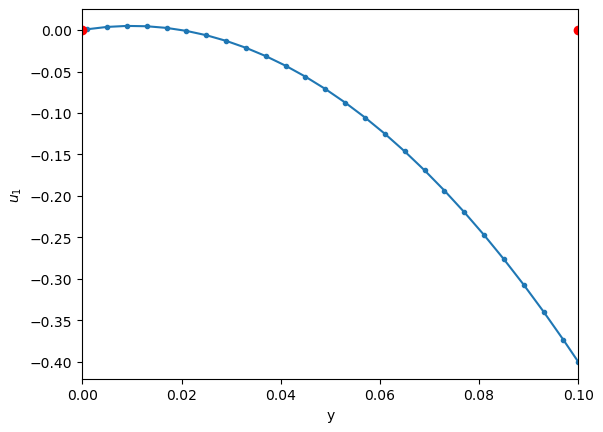

In [3]:
from scipy.integrate import solve_ivp

d = 0.1  # plate spacing
mu = 1  # vicsosity
Pdrop = -100  # dP/dx


def odefun(y, U):
    """
    takes in U, a length-2 vector containing u1 and u2.
    Returns a length-2 vector containing du1/dy and du2/dy
    where u1 = u (velocity of fluid) and u2 = du1/dy
    """
    u1, u2 = U
    du1dy = u2
    du2dy = Pdrop / mu
    return (du1dy, du2dy)


u1_0 = 0  # known
u2_0 = 1  # guessed

solution = solve_ivp(odefun, (0, d), (u1_0, u2_0), max_step=d / 25)


def plot_results(solution):
    y = solution.t
    U = solution.y
    plt.plot(y, U[0, :], ".-", label="Shooting method")
    plt.plot([0, d], [0, 0], "ro")  # the boundary values as red circles
    plt.xlim(0, d)
    plt.xlabel("y")
    plt.ylabel("$u_1$")


plot_results(solution)

Too low! Guess higher

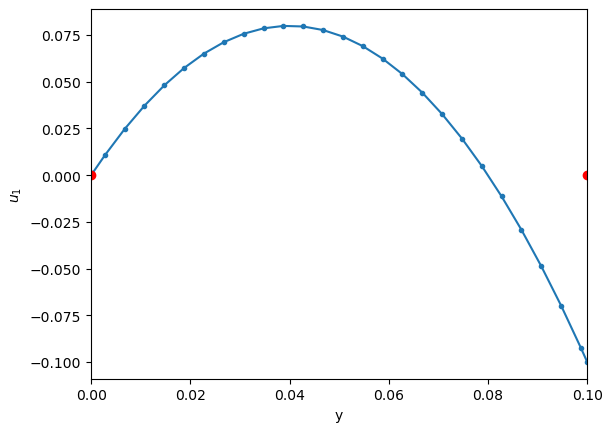

In [4]:
u1_0 = 0  # known
u2_0 = 4  # guessed higher than last time

solution = solve_ivp(odefun, (0, d), (u1_0, u2_0), max_step=d / 25)
plot_results(solution)

Rather than keep guessing, let's use a nonlinear solver to converge upon the best value for `u2_0`

In [5]:
from scipy.optimize import fsolve

# For documentation, uncomment the following line:
# fsolve?

# Signature:
# fsolve(
#    func,
#    x0,...)
# Docstring:
# Find the roots of a function.
# 
# Return the roots of the (non-linear) equations defined by
# ``func(x) = 0`` given a starting estimate.


In [6]:
# solve the IVP
solution = solve_ivp(odefun, (0, d), (u1_0, u2_0))
# get the last value of u1 (i.e. the last column of the first row of U)
solution.y[0, -1]
# this should be 0, the no-slip boundary condition at y=d

-0.1

Optimized u2 is 5.0


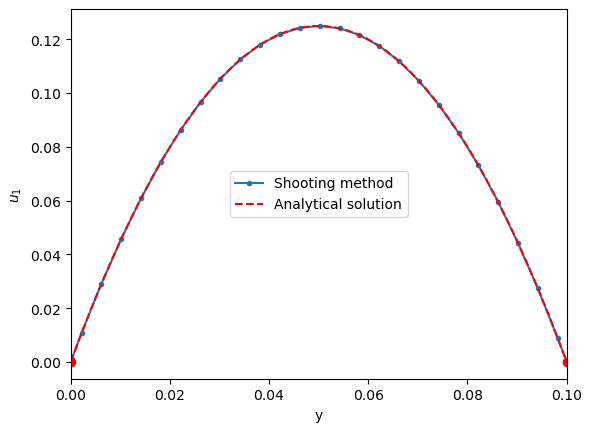

In [7]:
from scipy.optimize import fsolve

u1_0 = 0  # known


def objective(u2_0):
    """
    The thing we want to set equal to zero
    """
    # When this is called by fsolve, u2_0 will be given
    # as an array (with one element). This will cause deprecation
    # warnings if passed as an initial condition to solve_ivp
    # so we extract the zeroth (only) element from it:
    u2_0 = u2_0[0]
    solution = solve_ivp(odefun, (0, d), (u1_0, u2_0))
    return solution.y[0, -1]


(u2_0,) = fsolve(objective, 1.0)
print(f"Optimized u2 is {u2_0}")

# now solve with optimal u2_0
solution = solve_ivp(odefun, (0, d), (u1_0, u2_0), max_step=d / 25)
plot_results(solution)

# Also plot an analytical solution
dspan = np.linspace(0, d)
u = -(Pdrop) * d**2 / 2 / mu * (dspan / d - (dspan / d) ** 2)
plt.plot(dspan, u, "r--", label="Analytical solution")
plt.legend(loc="best")

plt.show()

## Finite difference (second order, one dimension)
Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-4-2 which was
adapted from http://www.physics.arizona.edu/~restrepo/475B/Notes/sourcehtml/node24.html which is a dead link.


For this example, we solve the plane poiseuille flow problem using a finite difference approach. An advantage of the approach we use here is we do not have to rewrite the second order ODE as a set of coupled first order ODEs, nor do we have to provide guesses for the solution. We do, however, have to discretize the derivatives and formulate a linear algebra problem.


> A reminder:
In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):
$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$
with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.
As before we let the plate separation be $d=0.1$, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.


The idea behind the finite difference method is to approximate the derivatives by finite differences on a grid. 

Using central differences
$$\frac{d^2u}{dy^2} = \frac{1}{\mu} \frac{\Delta P}{\Delta x}$$
becomes
$$\frac{u_{i-1} - 2 u_{i} + u_{i+1}}{h^2} = \frac{1}{\mu} \frac{\Delta P}{\Delta x} = -100$$


By discretizing the ODE, we arrive at a set of linear algebra equations of the form $A y = b$, where $A$ and $b$ are defined as follows.

$$
A = \left [ \begin{array}{ccccc} %
 2         & -1  & 0                    & 0 & 0 \\
-1  & 2          & -1 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & -1& 2 & -1  \\
0                    & 0                    & 0  & -1  & 2 \end{array} \right ] $$


$$ y = \left [ \begin{array}{c} y_i \\ \vdots \\ y_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} 100 h^2   \\
 100 h^2 \\
\vdots \\
 100 h^2 \\
 100 h^2 \end{array} \right] 
$$




If we want to solve a **linear boundary value problem** of the **general form**: 
$$y'' = p(x)y' + q(x)y + r(x)$$
with boundary conditions $y(x_1) = \alpha$ and $y(x_2) = \beta$.
then we arrive at a set of linear algebra equations of the form $A y = b$, where $A$ and $b$ are defined as follows.

$$
A = \left [ \begin{array}{ccccc} %
 2 + h^2 q_1         & -1 + \frac{h}{2} p_1 & 0                    & 0 & 0 \\
-1 - \frac{h}{2} p_2 & 2 + h^2 q_2          & -1 + \frac{h}{2} p_2 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & -1 - \frac{h}{2} p_{N-1} & 2 + h^2 q_{N-1} & -1 + \frac{h}{2} p_{N-1} \\
0                    & 0                    & 0  & -1 - \frac{h}{2} p_N & 2 + h^2 q_N \end{array} \right ] $$


$$ y = \left [ \begin{array}{c} y_i \\ \vdots \\ y_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} -h^2 r_1 + ( 1 + \frac{h}{2} p_1) \alpha \\
-h^2 r_2 \\
\vdots \\
-h^2 r_{N-1} \\
-h^2 r_N + (1 - \frac{h}{2} p_N) \beta \end{array} \right] 
$$

Mapping our $u'' = \frac{1}{\mu} \frac{\Delta P}{\Delta x}$ onto the general form $$y'' = p(x)y' + q(x)y + r(x)$$ with boundary conditions $y(x_1) = \alpha$ and $y(x_2) = \beta$, we see $p(x)=0$, $q(x)=0$, $r(x)=-100$, $\alpha=0$, $\beta=0$.

In [8]:
# For documentation, uncomment the following line:
# np.linalg.solve?

# Signature: np.linalg.solve(a, b)
# Docstring:
# Solve a linear matrix equation, or system of linear scalar equations.
# 
# Computes the "exact" solution, `x`, of the well-determined, i.e., full
# rank, linear matrix equation `ax = b`.


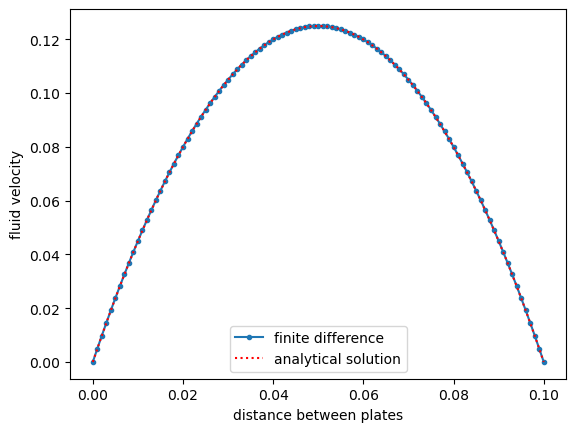

In [6]:
"""
This is set up for general p, q, r, alpha, beta
"""
# we use the notation for y'' = p(x)y' + q(x)y + r(x)


def p(x):
    return 0


def q(x):
    return 0


def r(x):
    return -100


# We use the notation y(x1) = alpha and y(x2) = beta
x1 = 0
alpha = 0.0
x2 = 0.1
beta = 0.0

npoints = 100

# compute interval width
h = (x2 - x1) / npoints

# preallocate and shape the b vector and A-matrix
b = np.zeros((npoints - 1, 1))
A = np.zeros((npoints - 1, npoints - 1))
X = np.zeros((npoints - 1, 1))

# now we populate the A-matrix and b vector elements
for i in range(npoints - 1):
    X[i, 0] = x1 + (i + 1) * h

    # get the value of the BVP Odes at this x
    pi = p(X[i])
    qi = q(X[i])
    ri = r(X[i])

    if i == 0:
        # first boundary condition
        b[i] = -(h**2) * ri + (1 + h / 2 * pi) * alpha
    elif i == npoints - 1:
        # second boundary condition
        b[i] = -(h**2) * ri + (1 - h / 2 * pi) * beta
    else:
        b[i] = -(h**2) * ri  # intermediate points

    for j in range(npoints - 1):
        if j == i:  # the diagonal
            A[i, j] = 2 + h**2 * qi
        elif j == i - 1:  # left of the diagonal
            A[i, j] = -1 - h / 2 * pi
        elif j == i + 1:  # right of the diagonal
            A[i, j] = -1 + h / 2 * pi
        else:
            A[i, j] = 0  # off the tri-diagonal

# solve the equations A*y = b for Y
Y = np.linalg.solve(A, b)

x = np.hstack([x1, X[:, 0], x2])
y = np.hstack([alpha, Y[:, 0], beta])

plt.plot(x, y, ".-", label="finite difference")

mu = 1
d = 0.1
x = np.linspace(0, 0.1)
Pdrop = -100  # this is DeltaP/Deltax
u = -(Pdrop) * d**2 / 2.0 / mu * (x / d - (x / d) ** 2)
plt.plot(x, u, "r:", label="analytical solution")

plt.xlabel("distance between plates")
plt.ylabel("fluid velocity")
plt.legend(loc="best")

## Exercise: convergence
Change the number of grid points and see how the solution changes.
What do you notice?

## Boundary conditions
This example had a *Dirichlet boundary condition* (fixed value). What if you had a *Neumann boundary condition* (fixed derivative)??
An example is solving for temperature $T(x)$ you may specify thermal insulation ($dT/dx=0$) at one boundary instead of a fixed temperature.

In [10]:
# Good question! (...for homework!!!?)

# PDEs - method of lines

Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-5-1

The PDE that describes the transient behavior of a plug flow reactor with constant volumetric flow rate is:
$$ \frac{\partial C_A}{\partial t} = -v_0 \frac{\partial C_A}{\partial V} + r_A $$

To solve this numerically in python, we will utilize the method of lines. The idea is to discretize the reactor in volume, and approximate the spatial derivatives by finite differences. Then we will have a set of coupled ordinary differential equations that can be solved in the usual way. Let us simplify the notation with $C = C_A$, and let $r_A = -k C^2$. Graphically this looks like this:

![pde-method-of-lines](http://kitchingroup.cheme.cmu.edu/pycse/images/pde-method-of-lines.png)

This leads to the following set of equations:

\begin{eqnarray}
\frac{dC_0}{dt} &=& 0 \text{ (entrance concentration never changes)} \\
\frac{dC_1}{dt} &=& -v_0 \frac{C_1 - C_0}{V_1 - V_0} - k C_1^2 \\
\frac{dC_2}{dt} &=& -v_0 \frac{C_2 - C_1}{V_2 - V_1} - k C_2^2 \\
\vdots \\
\frac{dC_4}{dt} &=& -v_0 \frac{C_4 - C_3}{V_4 - V_3} - k C_4^2
\end{eqnarray}

Last, we need initial conditions for all the nodes in the discretization. Let us assume the reactor was full of empty solvent, so that $C_i = 0$ at $t=0$. In the next block of code, we get the transient solutions, and the steady state solution.

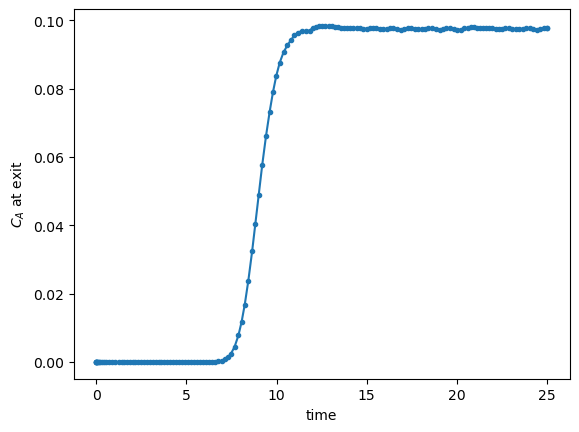

In [9]:
from scipy.integrate import solve_ivp

Ca0 = 2  # Entering concentration
vo = 2  # volumetric flow rate
volume = 20  # total volume of reactor, spacetime = 10 s
k = 1  # reaction rate constant

N = 100  # number of points to discretize the reactor volume on

init = np.zeros(N)  # Concentration in reactor at t = 0
init[0] = Ca0  # concentration at entrance

V = np.linspace(0, volume, N)  # discretized volume elements
tspan = (0, 25)  # time span to integrate over


def method_of_lines(t, C):
    """
    coupled ODES at each node point.

    Takes a vector of C values (one at each of the N volume elements).
    Returns a vector of dC/dt values
    """
    dCdt = np.zeros_like(C)
    for i in range(1, N):
        dCdt[i] = -vo * (C[i] - C[i - 1]) / (V[i] - V[i - 1]) - k * C[i] * C[i]
    dCdt[0] = 0
    return dCdt


sol = solve_ivp(method_of_lines, tspan, init)

plt.plot(sol.t, sol.y[-1], ".-")
plt.xlabel("time")
plt.ylabel("$C_A$ at exit")
plt.show()

After approximately one space time (10 s), the steady state solution is reached at the exit. 

## Exercise: convergence
Change the number of grid points and see how the solution changes.
What do you notice? Is the smooth S-shaped curve the correct solution to your model?

## Steady State solution
For completeness, we also examine the steady state solution, and compare it to the solution at 25 seconds.

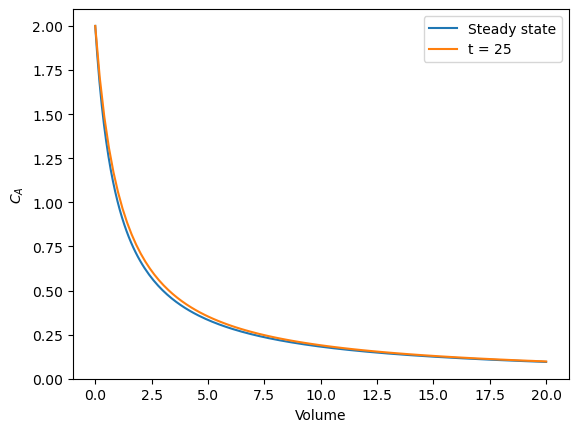

In [10]:
# steady state solution
def pfr(V, C):
    """
    returns dC/dV for a PFR
    """
    return 1.0 / vo * (-k * C**2)


ssol = solve_ivp(pfr, (0, volume), [Ca0], max_step=0.1)

plt.plot(ssol.t, ssol.y[0], label="Steady state")

# The PDE solution as a function of distance, at last timepoint
plt.plot(V, sol.y[:, -1], label=f"t = {tspan[-1]}")
plt.xlabel("Volume")
plt.ylabel("$C_A$")
plt.legend(loc="best")
plt.show()

There is some minor disagreement between the final transient solution and the steady state solution. That is due to the approximation in discretizing the reactor volume. In this example we used 100 nodes. You get better agreement with a larger number of nodes, say 200 or more. Of course, it takes slightly longer to compute then, since the number of coupled odes is equal to the number of nodes.



In [13]:
# Exercise: try discretizing with time and integrating with Volume


## Movie time!
Everyone loves an animation. Here's how to make one with matplotlib.

In [ ]:
conda install ffmpeg

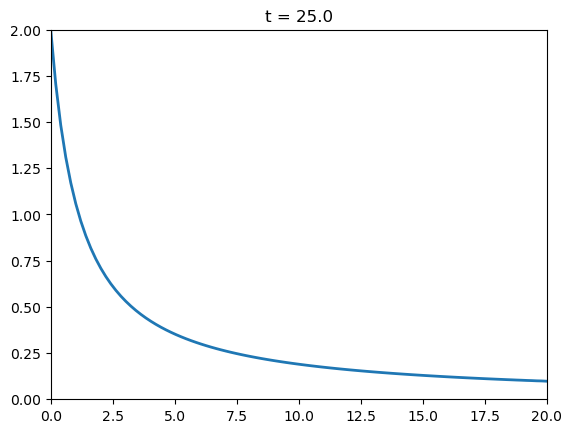

In [11]:
"""
Note that you will need to install ffmpeg or mencoder. Simplest way is probably:
    conda install ffmpeg
or if that fails then try
    conda install -c rmg ffmpeg
"""

# For the animation, we want to generate results at specific evenly spaced timesteps,
# not just let the ODE solver choose them. So we'll solve it again using t_eval
import matplotlib
from matplotlib import animation

frames = 51
timesteps = np.linspace(0, 25, frames)
sol = solve_ivp(method_of_lines, tspan, init, t_eval=timesteps)

matplotlib.rc("animation", html="html5")
# make empty figure
fig = plt.figure()
ax = plt.axes(xlim=(0, 20), ylim=(0, 2))
(line,) = ax.plot(V, init, lw=2)


def animate(i):
    # Change just the things you want to change
    line.set_xdata(V)
    line.set_ydata(sol.y[:, i])
    ax.set_title("t = {0:.1f}".format(sol.t[i]))
    ax.figure.canvas.draw()
    return (line,)


anim = animation.FuncAnimation(fig, animate, frames=frames, blit=True)
anim

## Transient heat conduction
Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-5-2 which is
adapated from http://msemac.redwoods.edu/~darnold/math55/DEproj/sp02/AbeRichards/slideshowdefinal.pdf
which is a dead link

We examine the transient behavior of a rod at constant T put between two heat reservoirs at different temperatures, T1 = 100, and T2 = 200. 
The rod will start at 150. Over time, we should expect a solution that approaches the steady state solution: a linear temperature profile from one side of the rod to the other.

$$\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2}$$

at $t=0$, in this example we have $u_0(x) = 150$ as an initial condition, with boundary conditions $u(0,t)=100$ and $u(L,t)=200$.

In Matlab there is the pdepe command. There is not yet a PDE solver in scipy. Instead, we will utilze the method of lines to solve this problem. We discretize the rod into segments, and approximate the second derivative in the spatial dimension as 
$$\frac{\partial^2 u}{\partial x^2} = \frac{(u(x + h) - 2 u(x) + u(x-h))}{ h^2}$$
at each node. This leads to a set of coupled ordinary differential equations that is easy to solve.

Let us say the rod has a length of 1, $k=0.02$, and solve for the time-dependent temperature profiles.

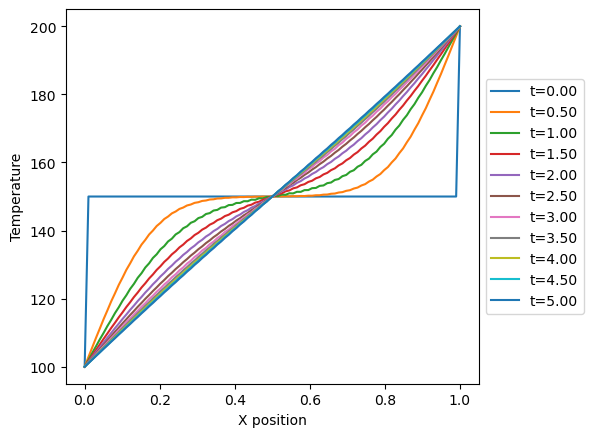

In [12]:
N = 100  # number of points to discretize
L = 1.0
X = np.linspace(0, L, N)  # position along the rod
h = L / (N - 1)

k = 0.02


def odefun(t, U):
    """Takes in t,U and returns dU/dt"""
    dUdt = np.zeros_like(U)
    dUdt[1:-1] = k * np.diff(U, n=2) / h / h
    return dUdt
    # raise NotImplementedError("Write this function...")


init = 150.0 * np.ones(X.shape)  # initial temperature
init[0] = 100.0  # one boundary condition
init[-1] = 200.0  # the other boundary condition

t_span = (0, 5.0)
t_steps = np.linspace(*t_span,51)

solution = solve_ivp(odefun, t_span, init, t_eval=t_steps )

for i in range(0, len(t_steps), 5):
    plt.plot(X, solution.y[:,i], label="t={0:1.2f}".format(t_steps[i]))

# put legend outside the figure
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("X position")
plt.ylabel("Temperature")

# adjust figure edges so the legend is in the figure
plt.subplots_adjust(top=0.89, right=0.77)

In [16]:
# Try it again using np.diff and see if it's better

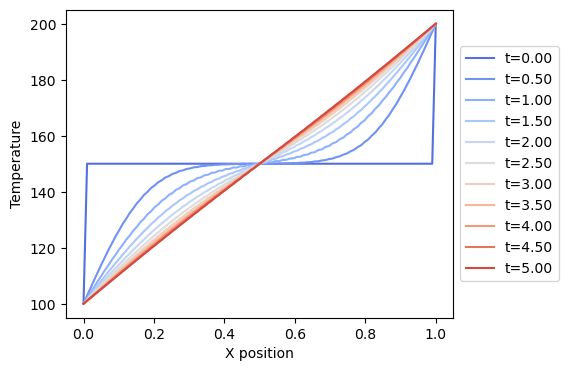

In [17]:
"""
You'll neeed to
    conda install seaborn
"""
import seaborn as sns

plt.figure(figsize=(5, 4))
num_lines = int(len(t_steps) / 5) + 1
sns.set_palette(sns.color_palette("coolwarm", num_lines))
for i in range(0, len(t_steps), 5):
    plt.plot(X, solution.y[:,i], label="t={0:1.2f}".format(t_steps[i]))

# put legend outside the figure
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("X position")
plt.ylabel("Temperature")
plt.show()

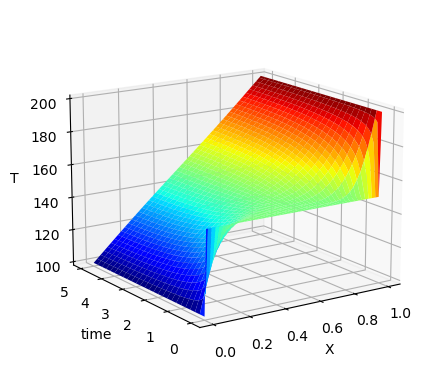

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

SX, ST = np.meshgrid(X, t_steps)
ax.plot_surface(SX, ST, solution.y.T, cmap="jet")  # The `.T` does a transpose of the matrix, swapping the rows and columns.
ax.set_xlabel("X")
ax.set_ylabel("time")
ax.set_zlabel("T")
ax.view_init(elev=15, azim=-124)  # adjust view so it is easy to see

## Transient diffusion, PDEs, Finite Difference discretization
Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-5-3
See also: http://coast.nd.edu/jjwteach/www/www/441/PdfNotes/lecture16.pdf

We want to solve for the concentration profile of component that diffuses into a 1D rod, with an impermeable barrier at the end. The PDE governing this situation is:

$$\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}$$

In this example we have $C_0(x) = 0$ at $t=0$ as an initial condition, with boundary conditions $C(0,t)=0.1$ and $\frac{\partial C}{\partial x}(L,t)=0$.

We are going to discretize this equation in both time and space to arrive at the solution. We will let $i$ be the index for the spatial discretization, and $j$ be the index for the temporal discretization. The discretization looks like this.

![pde-diffusion-discretization-scheme](http://kitchingroup.cheme.cmu.edu/pycse/images/pde-diffusion-discretization-scheme.png)

Note that we cannot use the method of lines as we did before because we have the derivative-based boundary condition at one of the boundaries.

We approximate the time derivative as:

$$\frac{\partial C}{\partial t} \bigg| _{i,j} \approx \frac{C_{i,j+1} - C_{i,j}}{\Delta t} $$

$$\frac{\partial^2 C}{\partial  x^2} \bigg| _{i,j} \approx \frac{C_{i+1,j} - 2 C_{i,j} + C_{i-1,j}}{h^2} $$

We define $\alpha = \frac{D \Delta t}{h^2}$, and from these two approximations and the PDE, we solve for the unknown solution at a later time step as:

$$C_{i, j+1} = \alpha C_{i+1,j} + (1 - 2 \alpha) C_{i,j}  + \alpha C_{i-1,j} $$

We know $C_{i,j=0}$ from the initial conditions, so we simply need to iterate to evaluate $C_{i,j}$, which is the solution at each time step.



0.36136136136136143


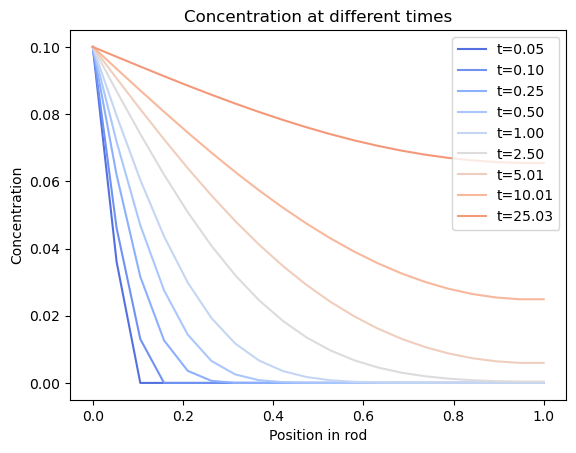

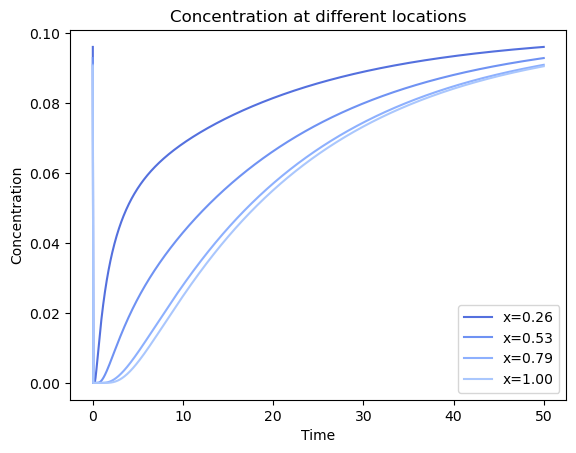

In [19]:
N = 20  # number of points to discretize
L = 1.0
X = np.linspace(0, L, N)  # position along the rod
h = L / (N - 1)  # discretization spacing

C0t = 0.1  # concentration at x = 0
D = 0.020  # Diffusivity.  (Try increasing this to 0.028 or higher....)

tfinal = 50.0
Ntsteps = 1000
dt = tfinal / (Ntsteps - 1)
t = np.linspace(0, tfinal, Ntsteps)

alpha = D * dt / h**2
print(alpha)

C_xt = []  # container for all the time steps

# initial condition at t = 0
C = np.zeros(X.shape)
C[0] = C0t

C_xt += [C]

for j in range(1, Ntsteps):
    N = np.zeros(C.shape)
    N[0] = C0t
    N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
    N[-1] = N[-2]  # derivative boundary condition flux = 0
    C[:] = N
    C_xt += [N]

    # plot selective solutions
    # sns.set_palette(sns.color_palette("coolwarm",10))
    if j in [1, 2, 5, 10, 20, 50, 100, 200, 500]:
        plt.plot(X, N, label="t={0:1.2f}".format(t[j]))

plt.xlabel("Position in rod")
plt.ylabel("Concentration")
plt.title("Concentration at different times")
plt.legend(loc="best")
plt.show()


C_xt = np.array(C_xt)
plt.figure()
# sns.set_palette(sns.color_palette("coolwarm",4))
plt.plot(t, C_xt[:, 5], label="x={0:1.2f}".format(X[5]))
plt.plot(t, C_xt[:, 10], label="x={0:1.2f}".format(X[10]))
plt.plot(t, C_xt[:, 15], label="x={0:1.2f}".format(X[15]))
plt.plot(t, C_xt[:, 19], label="x={0:1.2f}".format(X[19]))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration at different locations")
plt.show()

Now copy the code and increase the diffusivity from $D=0.020$ to $D=0.028$ or $D=0.029$.
Or increase the number of points in the $x$ direction to discretize from 20 to something bigger. What happens? Can you get it stable again?

# Further reading

## Py-PDE
This package is probably worth a look.
https://py-pde.readthedocs.io/en/latest/getting_started.html#package-overview

> The main aim of the pde package is to simulate partial differential equations in simple geometries. Here, the time evolution of a PDE is determined using the method of lines by explicitly discretizing space using fixed grids. The differential operators are implemented using the finite difference method. For simplicity, we consider only regular, orthogonal grids, where each axis has a uniform discretization and all axes are (locally) orthogonal. Currently, we support simulations on CartesianGrid, PolarSymGrid, SphericalSymGrid, and CylindricalSymGrid, with and without periodic boundaries where applicable.

## SymPy
SymPy does symbolic mathematics (a bit like mathemetica or maple) in Python, so for things with analytical solutions, this can probably derive them:
https://docs.sympy.org/latest/modules/solvers/pde.html#pde



# Exercise
Try the rabbits and foxes again (start with simple ODEs not KMC) but have a grid of farms covering a large area.
Add terms for foxes and rabbits to migrate from one farm to a neighbouring farm.

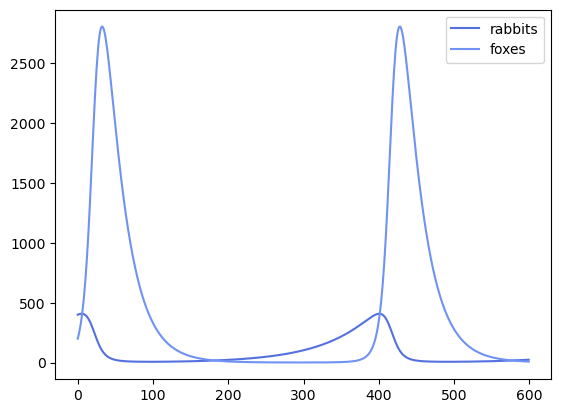

In [20]:
from scipy.integrate import odeint

k1 = 0.015
k2 = 0.00004
k3 = 0.0004
k4 = 0.04
end_time = 600.0


def rates(variables, time):
    """
    Return the right hand side of the ODE
    """
    rabbits, foxes = variables
    rate_rabbits = k1 * rabbits - k2 * rabbits * foxes
    rate_foxes = k3 * rabbits * foxes - k4 * foxes
    return (rate_rabbits, rate_foxes)


times = np.arange(0, end_time)
initial_conditions = (400.0, 200.0)
result = odeint(rates, initial_conditions, times)
rabbits = result[:, 0]
foxes = result[:, 1]
plt.plot(times, rabbits, label="rabbits")
plt.plot(times, foxes, label="foxes")
# put the legend at the best location to avoid overlapping things
plt.legend(loc="best")
plt.show()